In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import NamedTuple
import jax
import jax.numpy as jnp
import bayes3d
import genjax
import matplotlib.pyplot as plt

from src.genjax_distributions import (
    contact_params_uniform,
    image_likelihood,
    uniform_choice,
    uniform_discrete,
    uniform_pose
)
from src.masking_utils import mymatch

Construct a `console` object used for genjax pretty-printing:

In [3]:
console = genjax.console(enforce_checkify=True)

Set up a meshcat visualizer for Bayes3D:

In [4]:
bayes3d.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


# Object-generation model

First we define a type to store information about a given object in the scene:

In [5]:
class ObjectInfo(NamedTuple):
    parent_obj: int # Index of parent object in scene graph
                    # Is -1 if there is no parent object.
    parent_face: int # Face of parent object that this object is attached to
                     # 3 = top face
    child_face: int # Face of this object that is attached to parent
                    # 2 = bottom face
    category_index: int # Index of mesh in Bayes3D renderer for this object
    root_pose: jnp.ndarray # Object pose, if parent_object = -1
                           # (4, 4) pose matrix
    params: jnp.ndarray # (x, y, theta) coordinates of this object
                        # in the parent object's frame, if parent_object != -1

To best utilize GPU acceleration in GenJAX's model, we need a way to have a fixed memory layout throughout the inference process, even as the number of objects posited in the scene changes (as inference explores different possible numbers of latent objects).  To do this, we will allocate memory to store `max_n_object` ObjectInfo.  We will also set up a way of filling in a memory slot for an ObjectInfo with values that indicate that no actual object is represented.

In [6]:
def empty_object_info():
    """
    Placeholder ObjectInfo for a nonexistant object.
    (This way we can store "no object" instances in the same
    memory layout of an ObjectInfo.)
    """
    return ObjectInfo(
        jnp.array(-1000),
        jnp.array(-1000),
        jnp.array(-1000),
        jnp.array(-1000),
        jnp.zeros((4, 4)),
        -10000 * jnp.ones(3)
    )
def is_valid(obj: ObjectInfo):
    """
    Check if an object is valid (i.e. exists).
    """
    return obj.category_index >= 0

In [7]:
@genjax.static_gen_fn
def generate_object(
    object_idx : int,
    possible_category_indices, # Array of shape (n_categories, )
    pose_bounds, # Array of shape (3, 2): [[minx, miny, minz], [maxx, maxy, maxz]]
    contact_bounds # Array of shape (3, 2): [[minx, miny, mintheta], [maxx, maxy, maxtheta]]
):

    # Sample the index of a random object, lower than this object's index,
    # to be the parent object, or sample -1 to indicate that this
    # is a floating object.
    # Here, we only allow -1 to be sampled for the 0th object,
    # so that all subsequent objects are generated on the first object;
    # in a more flexible variant of this model this would not be strictly
    # enforced.
    min = jax.lax.select(object_idx == 0, -1, 0)
    parent_obj = uniform_discrete(min, object_idx) @ f"parent_obj"
  
    # Now sample the object category
    category_index = uniform_choice(possible_category_indices) @ f"category_index"

    # Sample the parent and child faces.
    # (In this notebook we always constrain it so that child = 2 and parent = 3,
    # so the child is on top of the parent.)
    parent_face = uniform_discrete(0, 6) @ f"face_parent"
    child_face = uniform_discrete(0, 6) @ f"face_child"
    
    # Generate a pose value.  If parent_obj = -1, ie. this object is floating,
    # this will be the object's pose.  Otherwise, this pose value
    # is ignored.
    root_pose = (
            uniform_pose(
                pose_bounds[0],
                pose_bounds[1],
            )
            @ f"root_pose"
        )
    
    # Generate an (x, y, theta) describing the pose of this object on the parent object.
    # If parent_obj = -1, this value will still be generated, but then ignored.
    contact_params = (
        contact_params_uniform(contact_bounds[0], contact_bounds[1])
        @ f"contact_params"
    )

    return ObjectInfo(parent_obj, parent_face, child_face, category_index, root_pose, contact_params)

Create a pseudo-random-number-generator (PRNG) key and generate a random trace from this generative function:

In [8]:
key = jax.random.PRNGKey(123)

generate_object_example_args = (
        0, # object index
        jnp.array([0, 1, 2, 3]), # possible_category_indices
        jnp.array([-2 * jnp.ones(3), 2 * jnp.ones(3)]), # pose_bounds
        jnp.array([jnp.array([-0.5, -0.5, -jnp.pi]), jnp.array([0.5, 0.5, jnp.pi])]) # contact_bounds
    )
trace = generate_object.simulate(
    key, # PRNG key
    generate_object_example_args
)

The trace stores a record of every random choice made during the generative process, and also the return value.
Here, the return value is the generated ObjectInfo:

In [9]:
console.print(trace.get_retval())

ObjectInfo(
    parent_obj=Array(-1, dtype=int32),
    parent_face=Array(4, dtype=int32),
    child_face=Array(1, dtype=int32),
    category_index=Array(1, dtype=int32),
    root_pose=Array([[-0.28899407,  0.75022423,  0.5946814 ,  1.0423379 ],
       [-0.926945  , -0.0640226 , -0.36969435, -0.49896955],
       [-0.23928067, -0.6580764 ,  0.7139187 ,  0.6713877 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32),
    params=Array([-0.04788339,  0.2073009 ,  1.5027282 ], dtype=float32)
)

We can also see the Gen ChoiceMap, which stores the names and values of all the random choices made during the generative process:

In [10]:
console.print(trace.get_choices())

(HierarchicalChoiceMap)
├── :category_index
│   └── (ValueChoice)
│       └──  i32[]
├── :parent_obj
│   └── (ValueChoice)
│       └──  i32[]
├── :face_parent
│   └── (ValueChoice)
│       └──  i32[]
├── :contact_params
│   └── (ValueChoice)
│       └──  f32[3]
├── :face_child
│   └── (ValueChoice)
│       └──  i32[]
└── :root_pose
    └── (ValueChoice)
        └──  f32[4,4]

In [11]:
console.print(trace.get_choices()["parent_obj"])

-1

In [12]:
# Or, syntactic sugar for the above:
console.print(trace["parent_obj"])

-1

## Masked object generation

We are ultimately going to write a model which generates a random number of objects, up to `max_n_objects`.
To facilitate inference on the GPU, in this notebook, we will set up the model in such a way that the memory layout of a `trace` object for the generative model is fixed, regardless of the number of objects in the trace.  (That is, we will allocate enough memory to store the biggest possible trace, and have a way to store in memory flag that indicate that parts of the memory have garbage values.)

To enable this, we are going to construct a _masked_ version of the `generate_object` function.  That is, we will construct a new generative function, `masked_generate_object`, which will accept as arguments:
1. A boolean `is_active`
2. A tuple of arguments to `generate_object`

This `masked_generate_object` function defines the following family of distributions (indexed by the arguments to the generative function):

1. If `is_active` is false, it is a distribution on the set `{Mask(false, None)}`.  That is, it is a distribution which always returns an object equivalent to the Python object `genjax.Mask(false, None)`.  In this case, the trace of the generative function will not contain any random choices, and the output probability is 1.0.
2. If `is_active` is true, it is a distribution on a space of values of the form `Mask(true, ObjectInfo)`, where the `ObjectInfo` is distributed according to `generate_object`.

In [13]:
masked_generate_object = genjax.masking_combinator(generate_object)

Let's generate a trace:

In [14]:
masked_generate_object_example_args = (
    True,
    generate_object_example_args
)
masked_trace = masked_generate_object.simulate(
    key, masked_generate_object_example_args
)

In [15]:
masked_object_info = masked_trace.get_retval()
console.print(masked_object_info)

(Mask, True)
└── ObjectInfo
    ├── parent_obj
    │   └──  i32[]
    ├── parent_face
    │   └──  i32[]
    ├── child_face
    │   └──  i32[]
    ├── category_index
    │   └──  i32[]
    ├── root_pose
    │   └──  f32[4,4]
    └── params
        └──  f32[3]

This is a `genjax.Mask` object with `mask = True`, meaning it indeed stores an object:

In [16]:
masked_object_info.mask

True

In [17]:
console.print(masked_object_info.unmask())

ObjectInfo(
    parent_obj=Array(-1, dtype=int32),
    parent_face=Array(4, dtype=int32),
    child_face=Array(1, dtype=int32),
    category_index=Array(1, dtype=int32),
    root_pose=Array([[-0.28899407,  0.75022423,  0.5946814 ,  1.0423379 ],
       [-0.926945  , -0.0640226 , -0.36969435, -0.49896955],
       [-0.23928067, -0.6580764 ,  0.7139187 ,  0.6713877 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32),
    params=Array([-0.04788339,  0.2073009 ,  1.5027282 ], dtype=float32)
)

Now let's run this function with `is_active = False`:

In [18]:
masked_trace_2 = masked_generate_object.simulate(
    key, (False, generate_object_example_args)
)

In [19]:
masked_object_info_2 = masked_trace_2.get_retval()
console.print(masked_object_info_2)

(Mask, False)
└── ObjectInfo
    ├── parent_obj
    │   └──  i32[]
    ├── parent_face
    │   └──  i32[]
    ├── child_face
    │   └──  i32[]
    ├── category_index
    │   └──  i32[]
    ├── root_pose
    │   └──  f32[4,4]
    └── params
        └──  f32[3]

This has masked_object_info_2.mask = False, meaning we should consider any bits stored in this `Mask` object to be garbage without semantic meaning.

In [20]:
masked_object_info_2.mask

False

The log probability of this trace is 0.0, that is, the probability of this trace is 1.0.  This is because no random choices were made in the generative process that produced this trace, which just returns a constant `Mask(false, None)` value (or some other sequence of bits considered semantically equivalent to this).

In [21]:
console.print(masked_trace_2.get_score())

0.0

Conversely, the first trace has nonzero log probability:

In [22]:
console.print(masked_trace.get_score())

-1.0969695

It is unsafe to call `Mask.unmask` on `Mask` values with `mask = False`.  Instead, genjax provides a `Mask.match` function which can be used to safely extract values from a `Mask`.

`Mask.match` accepts as input (1) a function that returns a default value to output when `mask = False`, and (2) a function of the data stored in the `Mask`, to output when `mask = True`.

In [23]:
get_default = lambda: -1000
get_cat_idx = lambda obj: obj.category_index
console.print(
    masked_object_info.match(get_default, get_cat_idx)
)

1

In [24]:
console.print(
    masked_object_info_2.match(get_default, get_cat_idx)
)

-1000

One restriction is that the two functions must return values which have the same "shape", meaning that Python and JAX understand how to fit the output values into the same memory layout.  This is why we defined the `empty_object_info` type above.

In [25]:
console.print(
    masked_object_info.match(
        lambda: empty_object_info(),
        lambda obj_info: obj_info
        )
)

ObjectInfo(
    parent_obj=Array(-1, dtype=int32, weak_type=True),
    parent_face=Array(4, dtype=int32, weak_type=True),
    child_face=Array(1, dtype=int32, weak_type=True),
    category_index=Array(1, dtype=int32, weak_type=True),
    root_pose=Array([[-0.28899407,  0.75022423,  0.5946814 ,  1.0423379 ],
       [-0.926945  , -0.0640226 , -0.36969435, -0.49896955],
       [-0.23928067, -0.6580764 ,  0.7139187 ,  0.6713877 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32),
    params=Array([-0.04788339,  0.2073009 ,  1.5027282 ], dtype=float32)
)

In [26]:
console.print(
    masked_object_info_2.match(
        lambda: empty_object_info(),
        lambda obj_info: obj_info
        )
)

ObjectInfo(
    parent_obj=Array(-1000, dtype=int32, weak_type=True),
    parent_face=Array(-1000, dtype=int32, weak_type=True),
    child_face=Array(-1000, dtype=int32, weak_type=True),
    category_index=Array(-1000, dtype=int32, weak_type=True),
    root_pose=Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32),
    params=Array([-10000., -10000., -10000.], dtype=float32)
)

> WARNING
>
> Currently, there is a bug in `genjax.Mask.match` which prevents it from being used in the code below.
>
> I have implemented a custom `mymatch` version which fixes this bug in the cases used in this notebook.  We will implement a fix in `genjax` soon.
>
> The rest of the notebook will use `mymatch(Mask, ...)` instead of `Mask.match(...)`.  Conceptually they are identical.

In [27]:
console.print(
    mymatch(masked_object_info,
        lambda: empty_object_info(),
        lambda obj_info: obj_info
        )
)

ObjectInfo(
    parent_obj=Array([-1], dtype=int32),
    parent_face=Array([4], dtype=int32),
    child_face=Array([1], dtype=int32),
    category_index=Array([1], dtype=int32),
    root_pose=Array([[-0.28899407,  0.75022423,  0.5946814 ,  1.0423379 ],
       [-0.926945  , -0.0640226 , -0.36969435, -0.49896955],
       [-0.23928067, -0.6580764 ,  0.7139187 ,  0.6713877 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32),
    params=Array([-0.04788339,  0.2073009 ,  1.5027282 ], dtype=float32)
)

In [28]:
console.print(
    mymatch(masked_object_info_2,
        lambda: empty_object_info(),
        lambda obj_info: obj_info
        )
)

ObjectInfo(
    parent_obj=Array([-1000], dtype=int32),
    parent_face=Array([-1000], dtype=int32),
    child_face=Array([-1000], dtype=int32),
    category_index=Array([-1000], dtype=int32),
    root_pose=Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32),
    params=Array([-10000., -10000., -10000.], dtype=float32)
)

## Generate many objects in parallel

Now, we're going to write a generative function which accepts as input a number `n_objects` of objects to generate (less than some maximum value `max_n_objects`), and returns a list of `n_objects` object info values.
To do this in a fixed memory footprint, we will acually have it always return a list of `max_n_objects` `Mask` objects, where the first `n_objects` have the form `Mask(True, ObjectInfo(...))`, and the rest have the form `Mask(false, garbage bits)`.

To make this generative function, we will use genjax's `map_combinator` constructor, which applies a generative function to a list of arguments in parallel, and returns a list of the results.  Its trace stores the trace for each sub-call.

In [29]:
mapper = genjax.map_combinator(
    # The `in_axes` tell the `map_combinator` which arguments to `masked_generate_object`
    # are mapped over, and which are not.
    # Each object slot may have a different `is_active` value, and a different object_index,
    # so we map over those;
    # but the other arguments are the same for each object, so we don't map over them.
    #    
    # The value `0` here tells genjax about how we will map over the arguments;
    # don't worry about this for now.
    in_axes = (
        0, # is_active is mapped over, along array axis 0
            (
                0, # object_index is mapped over along axis 0
                None, # possible_category_indices is not mapped over (it's the same for each object)
                None, # pose_bounds is not mapped over (it's the same for each object)
                None # contact_bounds is not mapped over (it's the same for each object)
            )
        )
)
generate_objects = mapper(masked_generate_object)

In [30]:
# Construct a trace for `generate_objects` with a memory layout
# that could store up to 8 objects.
max_n_objects = 8

# But let's just construct a trace with 3 objects actually used.
# The result of this will be a `trace` object stored in GPU memory
# with enough slots that we could later call `trace.update` to
# tell genjax to generate more objects in the 5 unused object slots.
n_objects = 3
is_active = (jnp.arange(max_n_objects) < 3) # Boolean array of shape (8,)
object_indices = jnp.arange(max_n_objects) # Array of shape (8,)

mapped_arguments = (
    is_active,
    (
        object_indices, # object_index

        # The last 3 arguments are the same for each sub-call to masked_generate_object.
        # In the construction of `generate_object`, we used the value in_axes=None
        # to tell genjax to expect one value for each of these, to be shared across
        # subcalls, rather than to expect an array of different values for each subcall.
        generate_object_example_args[1], # possible_category_indices
        generate_object_example_args[2], # pose_bounds
        generate_object_example_args[3] # contact_bounds
    )
)

mapped_trace = generate_objects.simulate(
    key,
    mapped_arguments
)

This trace's return value is, roughly, a list of 8 `Mask` objects.

Due to the way GenJAX (and JAX, the GPU library GenJAX builds on) works, the actual return value is a single python object of type `Mask`, but where the values inside the `Mask` are arrays of length 8.  

(JAX works by converting parallel calls to Python functions into calls of single GPU kernels on arrays that batch together the multiple inputs to the functions.  The result is a representation in which values processed in parallel live in arrays.  If python object wrappers are present, the python object ends up storing arrays rather than values within them.  It is a bit strange that the code looks like python objects storing arrays, rather than arrays storing python objects, but c'est la vie.)

In [31]:
console.print(mapped_trace.get_retval())

(Mask,  bool[8])
└── ObjectInfo
    ├── parent_obj
    │   └──  i32[8]
    ├── parent_face
    │   └──  i32[8]
    ├── child_face
    │   └──  i32[8]
    ├── category_index
    │   └──  i32[8]
    ├── root_pose
    │   └──  f32[8,4,4]
    └── params
        └──  f32[8,3]

Let's look at the array showing which objects are active:

In [32]:
console.print(mapped_trace.get_retval().mask)

[ True  True  True False False False False False]

To get the values stored in the masked objects, we use `Mask.match`, as described above.  (Due to the bug in `Mask.match`, we actually use `mymatch` in this notebook.)

In [33]:
mymatch(
    mapped_trace.get_retval(),
    lambda: -1000,
    lambda obj_info: obj_info.category_index
)

Array([    3,     0,     0, -1000, -1000, -1000, -1000, -1000], dtype=int32)

We see that we get the category info for the first 3 objects, and the Null value we specified in to `match` (here, -1000) for the other 5 slots.

We can unpack the full ObjectInfo values, using `empty_object_info()` as our null value:

In [34]:
object_info = mymatch(
        mapped_trace.get_retval(),
        lambda: empty_object_info(),
        lambda obj: obj
    )
console.print(object_info)

ObjectInfo(
    parent_obj=Array([   -1,     0,     1, -1000, -1000, -1000, -1000, -1000], dtype=int32),
    parent_face=Array([    5,     3,     0, -1000, -1000, -1000, -1000, -1000], dtype=int32),
    child_face=Array([    1,     4,     3, -1000, -1000, -1000, -1000, -1000], dtype=int32),
    category_index=Array([    3,     0,     0, -1000, -1000, -1000, -1000, -1000], dtype=int32),
    root_pose=Array([[[ 0.08324158,  0.9914397 ,  0.1005891 ,  0.78314924],
        [ 0.75845647,  0.00244164, -0.6517191 ,  0.15301752],
        [-0.6463858 ,  0.1305426 , -0.7517606 ,  1.4964514 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[-0.21666539, -0.90848744, -0.35736027, -0.21559906],
        [-0.8068098 , -0.03946489,  0.5894915 ,  0.3701434 ],
        [-0.5496488 ,  0.41604412, -0.7244262 , -1.6396523 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[-0.64909387,  0.70433265,  0.28738946,  1.4883456 ],
        [-0.08321178,  0.3097843 , -0.9471587 ,  1.5349431 ],
        [-0.7561435 , -0.63870907, -0.14247024,  1.9557447 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]],      dtype=float32),
    params=Array([[ 2.1488428e-01, -4.9679029e-01, -1.2526062e+00],
       [ 1.6291702e-01, -2.7761102e-01, -2.5685828e+00],
       [-2.4470484e-01,  4.0194654e-01, -1.6734682e+00],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04]], dtype=float32)
)

In [35]:
console.print(object_info.category_index)

[    3     0     0 -1000 -1000 -1000 -1000 -1000]

In [36]:
console.print(object_info.parent_obj)

[   -1     0     1 -1000 -1000 -1000 -1000 -1000]

Note that instead of giving us an array of 8 ObjectInfo values, we get a single ObjectInfo value, which contains arrays of length 8.

Again, this object-of-array rather than array-of-object format is typical of JAX's system for constructing parallel computations from python code.

## Full model over scenes and images

Now we'll define a generative model which generates a random set of objects, a camera pose, and then generates a noised-up image of the scene.

A few notes:
1. The first argument to this generative function needs to specify `max_n_objects`.  This needs to be done in a way that genjax knows that this value will not be changed at runtime, and it should compile a specialized version of the generative function, with a different fixed memory layout, for every value of `max_n_objects`.  GenJAX has an interface designed to support this, but it is currently unstable, so we use a work-around here.  The work-around is to pass in an array, `max_n_objects_array`, with shape `(max_n_objects,)`.  GenJAX always treats array shapes as fixed, so it will compile a specialized version of the generative function for every value of `max_n_objects`.  The values in the `max_n_objects_array` array are ignored.

In [37]:
# The trace will make it easy to access any value which is directly generated from
# a distribution object, like the noised-up image `trace["image"]`.
# For convenience, we will collect several values computed (but not directly sampled
# from distributions) in the generative process, and store them in a `ModelOutput` object.
# The generative function will return this value, so we can easily access these values
# from `trace.get_retval()`.
class ModelOutput(NamedTuple):
    rendered: jnp.ndarray
    n_objects: int
    object_info: ObjectInfo
    poses: jnp.ndarray

In [38]:
@genjax.static_gen_fn
def model(
    max_n_objects_array, # array with shape = (max n objects,)
    possible_object_indices, # Array, shape = (n_objects,)
    pose_bounds, # Array of shape (3, 2): [[minx, miny, minz], [maxx, maxy, maxz]]
    contact_bounds, # Array of shape (3, 2): [[minx, miny, mintheta], [maxx, maxy, maxtheta]]
    
    # Last arg: bounding box dimensions for the object mesh for each category,
    # [xsize, ysize, zsize], in meters.
    all_box_dims # Array of shape (n_categories, 3)
):
    ### Generate the objects in the scene ###

    # Choose a random number of objects to generate
    max_n_objects = max_n_objects_array.shape[0]
    n_objects = uniform_discrete(0, max_n_objects) @ "n_objects"

    masked_object_info = generate_objects(
        jnp.arange(max_n_objects) < n_objects, # is-active array
        (
            jnp.arange(max_n_objects), # object_index
            possible_object_indices,
            pose_bounds,
            contact_bounds
        )
    ) @ "objects"

    # Get the underlying ObjectInfo objects, or empty ones if they don't exist.
    object_info = mymatch(
        masked_object_info,
        lambda: empty_object_info(),
        lambda x: x
    )

    ### Compute the 6DOF object poses from the scene graph generated above ###
    
    # Bounding boxes dimensions for each object mesh; [0, 0, 0] for each null object slot
    valid_box_dims = jnp.where(
        is_valid(object_info)[:, None],
        all_box_dims[object_info.category_index],
        jnp.zeros(3)
    )
    # Compute the 6DOF poses of each object in the scene using
    # bayes3d.scene_graph.poses_from_scene_graph;
    # if the object is not valid, we just return jnp.zeros((4, 4)) to fill
    # a pose-shaped memory slot with null values.
    poses = jnp.where(
        is_valid(object_info)[:, None, None],
        bayes3d.scene_graph.poses_from_scene_graph(
            object_info.root_pose,
            valid_box_dims,
            object_info.parent_obj, object_info.params,
            object_info.parent_face, object_info.child_face
        ),
        jnp.zeros((max_n_objects, 4, 4))
    )

    ### Generate a camera pose and generate a picture of the scene ###
    camera_pose = uniform_pose(
        pose_bounds[0],
        pose_bounds[1],
    ) @ "camera_pose"
    rendered = bayes3d.RENDERER.render(jnp.linalg.inv(camera_pose) @ poses, object_info.category_index)[..., :3]\
    
    # Prior on noise parameters for the noisy image likelihood
    variance = genjax.uniform(0.00000000001, 10000.0) @ "variance"

    # Generate a noisy image of the scene
    noisy_image = image_likelihood(rendered, variance, 0.) @ "image"

    return ModelOutput(rendered, n_objects, object_info, poses)

## Set up Bayes3D's renderer, and generate some random scenes from the model

### Bayes3D setup

First, we need to set up the Bayes3D renderer with camera intrinsics and some known object meshes.

(Currently, camera intrinsics are fixed outside the generative model, rather than being an argument to the renderer, which could make it possible to, e.g., run inference over the intrinsics.)

In [50]:
from src.utils import load_nice_intrinsics, load_some_object_meshes, get_nice_table_pose

In [40]:
intrinsics = load_nice_intrinsics()
bayes3d.setup_renderer(intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 256, 1024)


In [41]:
idx_to_object_name = load_some_object_meshes()
idx_to_object_name

Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


['table',
 'pillar',
 '003_cracker_box',
 '004_sugar_box',
 '019_pitcher_base',
 '024_bowl',
 '061_foam_brick']

### Generate random scenes

In [42]:
# Update the PRNG key to the next one in the sequence
key, _ = jax.random.split(key)

model_args = (
    jnp.arange(max_n_objects), # max_n_objects_array
    jnp.arange(len(bayes3d.RENDERER.meshes)), # possible_object_indices
    jnp.array([-2 * jnp.ones(3), 2 * jnp.ones(3)]), # pose_bounds
    jnp.array([jnp.array([-0.5, -0.5, -jnp.pi]), jnp.array([0.5, 0.5, jnp.pi])],), # contact_bounds
    bayes3d.RENDERER.model_box_dims # all_box_dims
)
model_trace = model.simulate(key, model_args)

Visualize the trace in meshcat (open the URL returned by `b.setup_visualizer` at the top of this notebook to see this).  (Usually the URL is [http://127.0.0.1:7000/static/](http://127.0.0.1:7000/static/).)

In [43]:
from src.model3 import viz_trace_meshcat
viz_trace_meshcat(model_trace)

This tends to generate really random scenes where the camera isn't looking at anything of interest.

The depth images look like this:

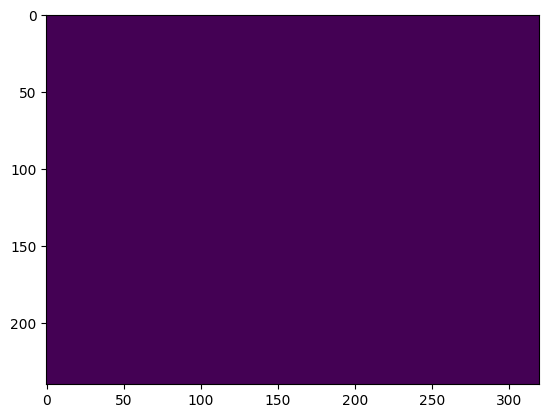

In [47]:
plt.imshow(model_trace.get_retval().rendered[:, :, 2])

Let's generate a new trace, telling Gen to constrain the choices so we get a particular trace, where the camera is facing the objects; the first object is the table; and all objects are on top of their parent object (rather than, e.g., being attached at the side).

In [48]:
# Utility function to reshape data as needed in GenJAX.
# (GenJAX TODO: make this easier.)
def flat_choicemaps_to_vector_choicemap(choicemaps):
    cm = genjax.choice_map({
        k : jnp.array([c.get_submap(k).get_value() for c in choicemaps])
        for (k, _) in choicemaps[0].get_submaps_shallow()
    })
    return cm

In [55]:
X_CameraTable = get_nice_table_pose()

constraints = genjax.choice_map({
    "camera_pose": jnp.eye(4), # identity camera pose
    "n_objects": 5,
    "objects": genjax.indexed_choice_map( # special choicemap type used by `map_combinator`
        jnp.arange(5),
        flat_choicemaps_to_vector_choicemap([
            genjax.choice_map({ # Object 1: table
                "root_pose": X_CameraTable,
                "parent_obj": -1, # no parent
                "category_index": 0, # table
                "face_parent": 2,
                "face_child": 3,
            }),
            *[
                genjax.choice_map({
                    "root_pose": jnp.eye(4),
                    "parent_obj": 0, # on table
                    "category_index": i + 2, # generate a few different object types
                    "face_parent": 2,
                    "face_child": 3,
                })
                for i in range(4)
            ]
        ])
    )
})

key, _ = jax.random.split(key)
model_trace_2, weight = model.importance(key, constraints, model_args)

In [56]:
viz_trace_meshcat(model_trace_2)

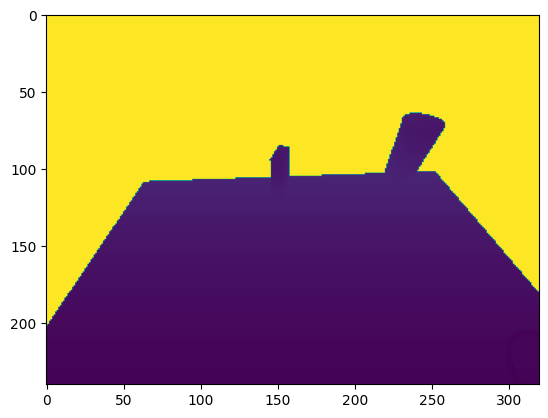

In [57]:
plt.imshow(model_trace_2.get_retval().rendered[:, :, 2])

### Compiling the model simulation function

It took a few seconds to generate the scene above, since it involved quite a bit of python logic.
We can tell GenJAX to just-in-time compile the scene generation to GPU (or CPU) code, which will make it run much faster.

In [59]:
# just-in-time compiled importance sampling function for generating traces
# consistent with constraints
importance_sampling_jit = jax.jit(model.importance)

In [62]:
# first call compiles it...
import time
start = time.time()
importance_sampling_jit(key, constraints, model_args)
end = time.time()
print(f"First call took {end - start} seconds")

First call took 0.0072307586669921875 seconds


In [64]:
# ...but subsequent calls are much faster
start = time.time()
importance_sampling_jit(key, constraints, model_args)
end = time.time()
print(f"Subsequent call took {end - start} seconds")

Subsequent call took 0.006575345993041992 seconds


This type of compilation is not as important for scene generation, but it can be quite important for inference, where we want to perform many operations on the model rapidly.

### Infernce from depth images

For a tutorial on running inference in this model, see [02_tutorial-mle-inference.ipynb](02_tutorial-mle-inference.ipynb).